# Data exploration and cleaning

In [47]:
import numpy as np
import pandas as pd
import seaborn
import os

from matplotlib import pyplot as plt
from numpy import log1p


## Import data

### for jupter Notebook

In [48]:
# Ensure the file exists in the current directory or provide the correct path
print("Current Working Directory:", os.getcwd())
file_path = 'data/charting-m-points.csv' 

data = pd.read_csv(file_path, encoding='latin1')
	
print(data.columns)

Current Working Directory: c:\Users\nicho\OneDrive\Documents\GitHub\TennisStrokePrediction


C:\Users\nicho\AppData\Local\Temp\ipykernel_22580\2372044445.py:5: DtypeWarning: Columns (7,12,24,25,26,31,32,33,34,35,45,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='latin1')


Index(['match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', 'Gm#', 'TbSet',
       'TB?', 'TBpt', 'Svr', 'Ret', 'Serving', '1st', '2nd', 'Notes',
       '1stNoLet', '2ndNoLet', '1stSV', '2ndSV', '1stNoSV', '2ndNoSV', '1stIn',
       '2ndIn', 'isRally1st', 'isRally2nd', 'Sv1', 'Sv2', 'Rally', 'isAce',
       'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble',
       'rallyNoSpec', 'rallyNoError', 'rallyNoDirection', 'rallyLen',
       'PtWinner', 'isSvrWinner', 'PtsAfter', 'GmW', 'Gm1.1', 'Gm2.1', 'SetW',
       'Set1.1', 'Set2.1', 'RevTB', 'TBrev', 'rallyCount'],
      dtype='object')


## Data cleaning

In [49]:
dropped_features = ["TbSet", "TBpt", "1st", "2nd", "Notes", "1stNoLet", "2ndNoLet", "1stSV", "2ndSV", "1stNoSV", "2ndNoSV", "1stIn", "2ndIn", "isRally1st", "isRally2nd", "Rally", "rallyNoSpec", "rallyNoDirection", "PtWinner", "isSvrWinner", "PtsAfter", 'GmW', 'Gm1.1', 'Gm2.1', 'SetW', 'Set1.1', 'Set2.1', "RevTB", "TBrev", "rallyCount"]

kept_features = ["Pt", "Set1", "Set2", "Gm1", "Gm2", "Pts", "Gm#", "TB?", "rallyLen"]

processing_features = [ "match_id", "Svr", "Ret", "Serving","Sv1", "Sv2","isAce", "isUnret", "isRallyWinner", "isForced", "isUnforced", "isDouble", "rallyNoError"]


data = data.drop(columns=dropped_features, errors='ignore')

# Split the data into two datasets
kept_features_data = data[kept_features].copy()
processing_features_data = data[processing_features].copy()

print("Kept Features Types:")
print(kept_features_data.dtypes)

print("\nProcessed Features Types:")
print(processing_features_data.dtypes)


Kept Features Types:
Pt            int64
Set1          int64
Set2          int64
Gm1           int64
Gm2         float64
Pts          object
Gm#          object
TB?         float64
rallyLen      int64
dtype: object

Processed Features Types:
match_id         object
Svr               int64
Ret              object
Serving          object
Sv1              object
Sv2              object
isAce              bool
isUnret          object
isRallyWinner    object
isForced         object
isUnforced       object
isDouble         object
rallyNoError     object
dtype: object


In [50]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
match_id              0
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   1
Pts                   0
Gm#                   1
TB?                  75
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205088
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
rallyLen              0
dtype: int64


# Process deduced features and compount features

In [51]:
def filter_data_by_player(data, target_player):
    """
    Filters the data for rows where the target player is playing.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Filtered dataset containing only rows where the target player is playing.
    """
    # Select "match_id" where target player is playing
    selected_match_ids = data.loc[data['Serving'] == target_player, 'match_id'].unique()

    # Filter rows in data where "match_id" is in the selected match_ids
    filtered_data = data[data['match_id'].isin(selected_match_ids)]
    
    return filtered_data

#In processing_data create "Svr" : 1 if the target player is serving, 0 if the target player is receiving
def create_svr_column(data, target_player): 
    """
    Creates a new column "Svr" in the dataset indicating if the target player is serving.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Updated dataset with the new "Svr" column.
    """
    data['Svr'] = np.where(data['Serving'] == target_player, 1, 0)
    return data

In [52]:
# define shot types to be mapped for our unforced error and winners array
shot_types = [
    'f', 'b',  # groundstrokes
    'r', 's',  # slices
    'v', 'z',  # volleys
    'o', 'p',  # overheads
    'u', 'y',  # drop shots
    'l', 'm',  # lobs
    'h', 'i',  # half-volleys
    'j', 'k',  # swinging volleys
    't', 'q'   # trick shots and unknown shots
]

# generate combinations with directions 1, 2, 3
shot_vocab = {f"{shot}{n}": idx for idx, (shot, n) in enumerate(
    (s, i) for s in shot_types for i in [1, 2, 3]
)}



In [87]:
import re
import numpy as np
import pandas as pd

def process_rally_data(df, shot_vocab):
    sequence_data = []
    direction_dict = {'1', '2', '3'}
    serve_dict={'4','5','6'}

    for _, row in df.iterrows():
        isServe = row['Svr'] == 1
        rally = str(row['rallyNoError'])

        if pd.isna(rally) or len(rally) < 2:
            continue

        debug_logs = []
        tokens = []

        # First shot: allow 1–2 digits
        match = re.match(r'^([a-zA-Z])(\d+)', rally)
        if not match:
            continue

        first_letter = match.group(1)
        digits = match.group(2)[:2]
        first_token = first_letter + digits[0]

        if first_token in shot_vocab:
            tokens.append(first_token)
        else:
            continue
        idx = len(match.group(0))

        # Extract remaining shots
        while idx + 2 <= len(rally):
            segment = rally[idx:idx+3]
            debug_logs.append(f"[{idx}] Segment: '{segment}'")

            if re.match(r'^[a-zA-Z]\d[a-zA-Z]$', segment):
                token = segment[0] + segment[1]
                debug_logs.append(f"[{idx}] Pattern A: {segment}")

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 2

            elif re.match(r'^[a-zA-Z]\d\d$', segment):
                debug_logs.append(f"[{idx}] Pattern B: {segment}")
                token1 = segment[0] + segment[1]
                token2 = segment[0] + segment[2]

                if segment[1] in direction_dict and token1 in shot_vocab:
                    tokens.append(token1)

                elif segment[2] in direction_dict and token2 in shot_vocab:
                    tokens.append(token2)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid tokens: {token1}, {token2}")
                    break
                idx += 3

            elif re.match(r'^[a-zA-Z][a-zA-Z]\d$', segment):
                debug_logs.append(f"[{idx}] Pattern C: {segment}")
                token = segment[1] + segment[2]

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 3

            else:
                debug_logs.append(f"[{idx}] Pattern D (Fallback): {segment}")

                if idx + 1 < len(rally):
                    ch1, ch2 = rally[idx], rally[idx + 1]
                    token = ch1 + ch2

                    if ch1.isalpha() and ch2 in direction_dict and token in shot_vocab:
                        tokens.append(token)
                        idx += 2

                    else:
                        debug_logs.append(f"[{idx}] ❌ Invalid fallback token: {token}")
                        break
                else:
                    break

        # Skip rallies with invalid parsing
        if any(log.startswith("❌") for log in debug_logs):
            print(f"\n🔍 Invalid rally at row {row.name}: {rally}")
            for log in debug_logs:
                print(log)
            continue

        # --- Serve Logic ---
        if not pd.isna(row['Sv1']) and row['Sv1'][0] in serve_dict:
            if not pd.isna(row['Sv2']) and row['Sv2'][0] in serve_dict:
                full_rally = [row['Sv1'][0], row['Sv2'][0]] + tokens
            else:
                full_rally = ['0', row['Sv1'][0]] + tokens
        else:
            continue

        # --- Label Arrays ---
        winner_array = np.zeros(54)
        unforced_array = np.zeros(54)

        final_shot = tokens[-1]
        idx = shot_vocab.get(final_shot, None)
        if idx is not None:
            if row['isRallyWinner']:
                winner_array[idx] += 1
            elif row['isUnforced']:
                unforced_array[idx] += 1

        # --- 3-Shot Sequence Construction ---
        i = 1 if isServe else 0
        while i + 2 < len(full_rally):
            new_row = row.to_dict()
            new_row['shot1'] = full_rally[i]
            new_row['shot2'] = full_rally[i + 1]
            new_row['shot3'] = full_rally[i + 2]
            new_row['winner_array'] = winner_array.copy()
            new_row['unforced_array'] = unforced_array.copy()
            sequence_data.append(new_row)
            i += 2

    return pd.DataFrame(sequence_data)


### Acutual processing

In [88]:
processing_data = data.copy()
target_player = "RF"

# Test the filter_data_by_player function
processing_data = filter_data_by_player(processing_data, target_player)

# Print the number of unique match IDs selected
num_unique_matches = len(processing_data['match_id'].unique())
print(f"Number of Unique Matches Found: {num_unique_matches}")

# Print the number of rows selected
num_rows_selected = processing_data.shape[0]
print(f"Number of Rows Selected: {num_rows_selected}")

# Calculate and print the sum of rally lengths for all rows
if 'rallyLen' in processing_data.columns:
    rally_len_sum = processing_data['rallyLen'].sum()
    print(f"Sum of Rally Lengths: {rally_len_sum}")
else:
    print("Column 'rallyLen' not found in the dataset.")

# Test the create_svr_column function
processing_data = create_svr_column(processing_data, target_player)

Number of Unique Matches Found: 322
Number of Rows Selected: 55713
Sum of Rally Lengths: 200252


In [89]:
sequence_data = process_rally_data(processing_data,shot_vocab=shot_vocab)
sequence_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95282 entries, 0 to 95281
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   match_id        95282 non-null  object 
 1   Pt              95282 non-null  int64  
 2   Set1            95282 non-null  int64  
 3   Set2            95282 non-null  int64  
 4   Gm1             95282 non-null  int64  
 5   Gm2             95282 non-null  float64
 6   Pts             95282 non-null  object 
 7   Gm#             95282 non-null  object 
 8   TB?             95282 non-null  float64
 9   Svr             95282 non-null  int64  
 10  Ret             95282 non-null  object 
 11  Serving         95282 non-null  object 
 12  Sv1             95282 non-null  object 
 13  Sv2             42649 non-null  object 
 14  isAce           95282 non-null  bool   
 15  isUnret         95282 non-null  object 
 16  isRallyWinner   95282 non-null  object 
 17  isForced        95282 non-null 

In [101]:
print("Unique labels in shot1:", np.unique(sequence_data['shot1']))

Unique labels in shot1: ['0' '4' '5' '6' 'b1' 'b2' 'b3' 'f1' 'f2' 'f3' 'h1' 'h2' 'h3' 'i1' 'i2'
 'i3' 'j1' 'j2' 'j3' 'k3' 'l1' 'l2' 'l3' 'm1' 'm2' 'm3' 'o1' 'o2' 'o3'
 'p1' 'p2' 'p3' 'q2' 'q3' 'r1' 'r2' 'r3' 's1' 's2' 's3' 't2' 'u1' 'u2'
 'u3' 'v1' 'v2' 'v3' 'y1' 'y2' 'y3' 'z1' 'z2' 'z3']


In [91]:
processed_data = sequence_data.drop(columns=processing_features, errors='ignore')

# split the Pts dataset into Pts1 for player 1's points and Pts2 for player 2's points for consistent int values
def split_pts(pts):
    try:
        p1, p2 = pts.split('-')
        return int(p1.strip()), int(p2.strip())
    except:
        return 0, 0  # default to 0 if invalid

# Split into two columns
processed_data[['Pts1', 'Pts2']] = processed_data['Pts'].apply(lambda x: pd.Series(split_pts(str(x))))

# Drop the original 'Pts' column since it's now encoded
processed_data.drop('Pts', axis=1, inplace=True)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95282 entries, 0 to 95281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pt              95282 non-null  int64  
 1   Set1            95282 non-null  int64  
 2   Set2            95282 non-null  int64  
 3   Gm1             95282 non-null  int64  
 4   Gm2             95282 non-null  float64
 5   Gm#             95282 non-null  object 
 6   TB?             95282 non-null  float64
 7   rallyLen        95282 non-null  int64  
 8   shot1           95282 non-null  object 
 9   shot2           95282 non-null  object 
 10  shot3           95282 non-null  object 
 11  winner_array    95282 non-null  object 
 12  unforced_array  95282 non-null  object 
 13  Pts1            95282 non-null  int64  
 14  Pts2            95282 non-null  int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 10.9+ MB


In [92]:
# convert the Gm# column into all integers for consistent values

import re

# Extract the first integer using regex and convert to int
processed_data['Gm#'] = processed_data['Gm#'].apply(lambda x: int(re.match(r'\d+', str(x)).group()) if re.match(r'\d+', str(x)) else 0)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95282 entries, 0 to 95281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pt              95282 non-null  int64  
 1   Set1            95282 non-null  int64  
 2   Set2            95282 non-null  int64  
 3   Gm1             95282 non-null  int64  
 4   Gm2             95282 non-null  float64
 5   Gm#             95282 non-null  int64  
 6   TB?             95282 non-null  float64
 7   rallyLen        95282 non-null  int64  
 8   shot1           95282 non-null  object 
 9   shot2           95282 non-null  object 
 10  shot3           95282 non-null  object 
 11  winner_array    95282 non-null  object 
 12  unforced_array  95282 non-null  object 
 13  Pts1            95282 non-null  int64  
 14  Pts2            95282 non-null  int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 10.9+ MB


In [93]:
processed_data['TB?'].fillna(0, inplace=True)

# Remove rows where 'Gm2' or 'Gm#' have missing values
processed_data.dropna(subset=['Gm2', 'Gm#'], inplace=True)

print("\nMissing values after handleing:")
print(processed_data.isnull().sum())


Missing values after handleing:
Pt                0
Set1              0
Set2              0
Gm1               0
Gm2               0
Gm#               0
TB?               0
rallyLen          0
shot1             0
shot2             0
shot3             0
winner_array      0
unforced_array    0
Pts1              0
Pts2              0
dtype: int64


In [94]:
# Backup dataset
processed_data.to_csv('data/processed_features.csv', index=False)

### quality check

In [95]:
# Copy the DataFrame to avoid altering the original
processed_data_xgb = processed_data.copy()

In [96]:
# score to index mapping
score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'A': 4, 'AD': 4}

# map and convert to int
processed_data_xgb['Pts1'] = processed_data_xgb['Pts1'].map(score_map).fillna(0).astype(int)
processed_data_xgb['Pts2'] = processed_data_xgb['Pts2'].map(score_map).fillna(0).astype(int)

In [103]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Copy the data
processed_data_xgb = processed_data.copy()

# xgboost only accepts numerical and categorical data, so we split the 54 size arrays into one column each
winner_df = pd.DataFrame(processed_data_xgb['winner_array'].tolist(), index=processed_data_xgb.index)
winner_df.columns = [f'winner_{i}' for i in range(winner_df.shape[1])]

unforced_df = pd.DataFrame(processed_data_xgb['unforced_array'].tolist(), index=processed_data_xgb.index)
unforced_df.columns = [f'unforced_{i}' for i in range(unforced_df.shape[1])]

# Drop the original object columns
processed_data_xgb.drop(columns=['winner_array', 'unforced_array'], inplace=True)

# Concatenate the unpacked columns
processed_data_xgb = pd.concat([processed_data_xgb, winner_df, unforced_df], axis=1)

# Step 1: Separate features and target BEFORE encoding
X = processed_data_xgb.drop(columns=['shot3'])
y_raw = processed_data_xgb['shot3']

# Step 2: Train-test split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)

# Step 3: Encode categorical feature columns
categorical_cols = ['Gm#', 'shot1', 'shot2']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    all_values = pd.concat([X_train[col], X_test[col]]).astype(str)
    le.fit(all_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Step 4: Encode target column (shot3)
le_target = LabelEncoder()
le_target.fit(pd.concat([y_train_raw, y_test_raw]))
y_train = le_target.transform(y_train_raw)
y_test = le_target.transform(y_test_raw)

# Step 5: Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Step 6: Evaluate
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))


c:\Users\nicho\anaconda3\envs\nnlm\lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:43] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 0.4956116759593309
Test Accuracy: 0.3780762974235189


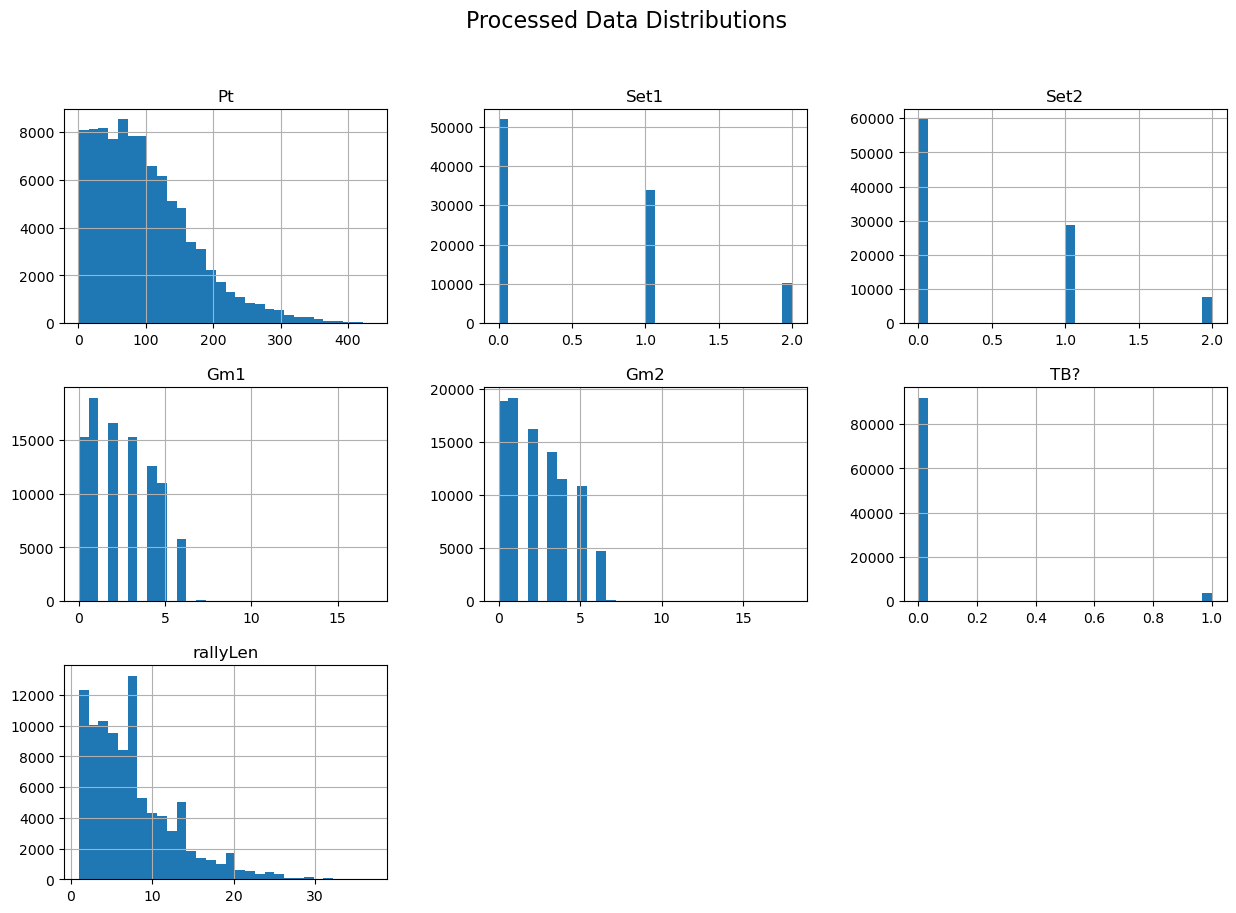

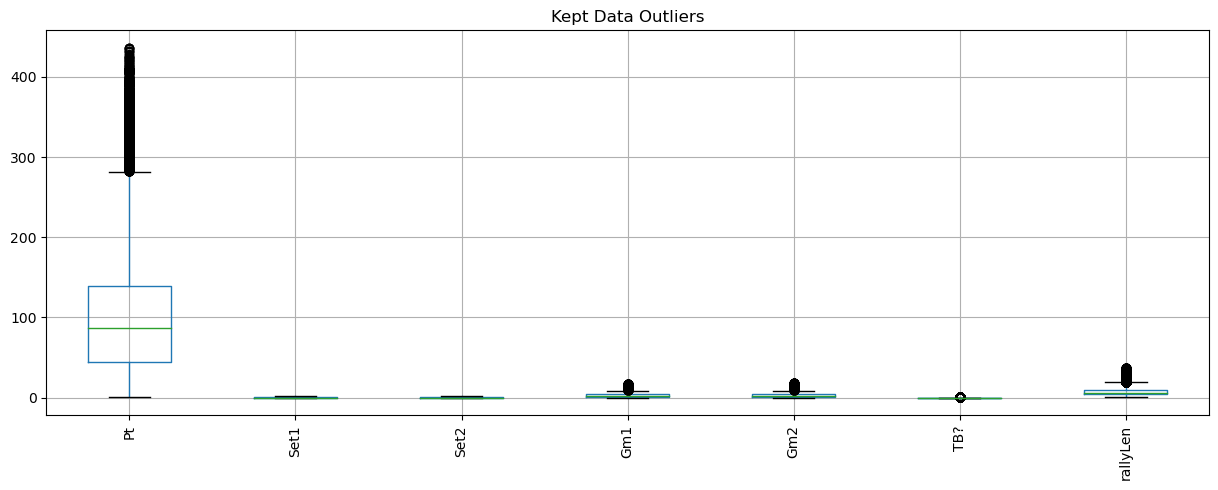


Processed Data Summary Statistics:
                 Pt          Set1          Set2           Gm1           Gm2  \
count  95874.000000  95874.000000  95874.000000  95874.000000  95874.000000   
mean      99.057763      0.565597      0.457069      2.527234      2.366742   
std       71.259350      0.676295      0.637225      1.902644      1.918722   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       44.000000      0.000000      0.000000      1.000000      1.000000   
50%       87.000000      0.000000      0.000000      2.000000      2.000000   
75%      139.000000      1.000000      1.000000      4.000000      4.000000   
max      436.000000      2.000000      2.000000     17.000000     18.000000   

                TB?      rallyLen  
count  95874.000000  95874.000000  
mean       0.039500      7.530811  
std        0.194782      5.272772  
min        0.000000      1.000000  
25%        0.000000      4.000000  
50%        0.000000      6.000000  


In [ ]:
# Visualize distributions to identify skewness
processed_data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Processed Data Distributions", fontsize=16)
plt.show()

# Visualize outliers using boxplots
plt.figure(figsize=(15, 5))
processed_data.boxplot()
plt.title("Kept Data Outliers")
plt.xticks(rotation=90)
plt.show()

print("\nProcessed Data Summary Statistics:")
print(processed_data.describe())